In [2]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#set paths for file navigation
BASE_DIR = pathlib.Path().resolve().parent
DATA_DIR = BASE_DIR / 'data'
RAW_DIR = DATA_DIR / 'raw'
PROCESSED_DIR = DATA_DIR / 'processed'

In [5]:
#set dataset file names as variables 
monthly_charges = 'Monthly charges in 2021.csv'
figures_by_plan_period = 'Figures grouped by plan and period.csv'
figures_by_type_period = 'Figures grouped by type and period.csv'

The next cell is an example of how we would download the data if we were to access BigQuery through Python directly. 

We would create a utils folder containing download_data.py, then import the functions here. Then we can call them while passing in the variables created above as file names.

The download_data.py file assumes the user is in a production environment, where they would have a service account key JSON file downloaded and stored, and accessed through the .env file.

However, in the interest of time, I did not set up full service account credentials on GCP as I would have to request them to be added to the original project. Hence, I will comment out the code and leave it as a template of how we could do it. 

In [59]:
# from utils.download_data import (
#     get_monthly_charges_2021,
#     get_groupby_plan,
#     get_groupby_type,
# )

# get_monthly_charges_2021(monthly_charges)
# get_groupby_plan(figures_by_plan_period)
# get_groupby_type(figures_by_type_period)


In [20]:
#read in the dataset, adding parse_dates for date columns
df_monthly_charges = pd.read_csv(RAW_DIR/monthly_charges, parse_dates=['charge_month','charged_on']) 
df_monthly_charges.head(5)

,id,subscription_id,organization_id,charge_month,charged_on,amount_usd,billed_user_count,plan,billing_period,type,last_month_subscription_id,last_month_amount_usd,last_month_billed_user_count,last_month_plan,last_month_billing_period,is_sales_driven
0,7744a4caece8ae9f338d13501db0b42f,384839.0,5505046,2021-08-01,2021-08-13,2.5,1,starter,Monthly,New,NaN,0.0,0,NaN,NaN,False
1,d2a88a8987f5fb49dc6cac616cf8bb94,380898.0,5503008,2021-08-01,2021-08-11,5.0,1,starter,Monthly,New,NaN,0.0,0,NaN,NaN,False
2,97d84c2fb047da1df0f305d8a015d043,137839.0,4387301,2021-01-01,2021-01-10,6.0,1,starter,Monthly,New,NaN,0.0,0,NaN,NaN,False
3,bde9557e0503ce4fff6fd9e00f9478a9,147851.0,4898576,2021-02-01,2021-02-15,7.0,1,starter,Monthly,New,NaN,0.0,0,NaN,NaN,False
4,91f46c7383ba79f25d8004a57f25923d,150441.0,689098,2021-03-01,2021-03-20,9.0,1,starter,Annual,New,NaN,0.0,0,NaN,NaN,False


In [22]:
#get all the categorical variables
cat_vars = [var for var in df_monthly_charges.columns if df_monthly_charges[var].dtype == 'O']

#we have to add org_id and org_owner_id as they are also categorical
cat_vars = cat_vars + ['organization_id', 'subscription_id', 'last_month_subscription_id']

#cast all categorical variables to dtype object
df_monthly_charges[cat_vars] = df_monthly_charges[cat_vars].astype('O')

In [50]:
df_monthly_charges.dtypes

id                                      object
subscription_id                         object
organization_id                         object
charge_month                    datetime64[ns]
charged_on                      datetime64[ns]
amount_usd                             float64
billed_user_count                        int64
plan                                    object
billing_period                          object
type                                    object
last_month_subscription_id              object
last_month_amount_usd                  float64
last_month_billed_user_count             int64
last_month_plan                         object
last_month_billing_period               object
is_sales_driven                           bool
month_charged_on                         int64
quarter_charged_on                       int64
dtype: object

In [23]:
df_monthly_charges.describe()

,amount_usd,billed_user_count,last_month_amount_usd,last_month_billed_user_count
count,222110.000000,222110.000000,222110.000000,222110.000000
mean,61.697800,5.865544,60.843960,5.817811
std,157.589518,16.965244,154.762971,17.155214
min,0.000000,0.000000,0.000000,0.000000
25%,9.000000,1.000000,9.000000,1.000000
50%,18.000000,1.000000,18.000000,1.000000
75%,70.000000,7.000000,63.000000,6.000000
max,9804.000000,1946.000000,9804.000000,1946.000000


First, I want to check if all assumptions about the dataset hold. Namely, uniqueness of the id columns as well as timeline of the dataset.

In [24]:
#each id should be unique
print(len(df_monthly_charges['id'].unique()) == len(df_monthly_charges)) 

True


In [25]:
#check "id" columns. Each row should be a unique subscription from 1 org on 1 date
df_monthly_charges[df_monthly_charges.duplicated(subset=['subscription_id', 'organization_id','charged_on'], keep=False)]

,id,subscription_id,organization_id,charge_month,charged_on,amount_usd,billed_user_count,plan,billing_period,type,last_month_subscription_id,last_month_amount_usd,last_month_billed_user_count,last_month_plan,last_month_billing_period,is_sales_driven


In [26]:
#any dates that are not from 2021?
print(df_monthly_charges['charged_on'].dt.year.value_counts())
print(df_monthly_charges['charge_month'].dt.year.value_counts())

2021    222110
Name: charged_on, dtype: int64
2021    222072
2022        38
Name: charge_month, dtype: int64


Uniqueness of "id" columns holds, which means that the assumption that each row is a unique charge is correct. 

It looks like column "charge_month" has dates from 2022. I am not entirely certain what this column entails, so let's take a closer look. 

In [27]:
df_monthly_charges[df_monthly_charges['charge_month'].dt.year == 2022]

,id,subscription_id,organization_id,charge_month,charged_on,amount_usd,billed_user_count,plan,billing_period,type,last_month_subscription_id,last_month_amount_usd,last_month_billed_user_count,last_month_plan,last_month_billing_period,is_sales_driven
7970,756e88e661a9b8ab161ca61b4b03e729,NaN,3981665,2022-01-01,2021-12-31,0.0,0,NaN,NaN,Churned,2788225.0,9.0,1,starter,Annual,False
8382,94cc8d524b564b96916df8890e87d17e,NaN,5405708,2022-01-01,2021-12-31,0.0,0,NaN,NaN,Churned,2787916.0,10.0,1,starter,Monthly,False
8765,9abdcd37bea4d594bddfe3a83d5dbfcb,NaN,5106907,2022-01-01,2021-12-31,0.0,0,NaN,NaN,Churned,2787672.0,10.0,1,starter,Monthly,False
8771,318d0f7d86f84f1887279734238d6747,NaN,4334346,2022-01-01,2021-12-31,0.0,0,NaN,NaN,Churned,2787799.0,10.0,1,starter,Monthly,False
8886,419315d778978d80364ee7484802f71f,NaN,2291958,2022-01-01,2021-12-31,0.0,0,NaN,NaN,Churned,2787879.0,18.0,1,premium,Annual,False
8992,92d41b7b1ddd84c7ee64bcc1690ee3eb,NaN,3995744,2022-01-01,2021-12-31,0.0,0,NaN,NaN,Churned,2788339.0,9.0,1,starter,Annual,False
9059,b67643d22c8e040149b0469531103e6f,NaN,5534730,2022-01-01,2021-12-31,0.0,0,NaN,NaN,Churned,2788247.0,20.0,1,premium,Monthly,False
9130,54a1d777b69be10e98a9ca728f6e2d9f,NaN,4866496,2022-01-01,2021-12-31,0.0,0,NaN,NaN,Churned,2788092.0,18.0,1,premium,Annual,False
9458,24356c23c0431900fd6949deabb4135d,NaN,3199356,2022-01-01,2021-12-31,0.0,0,NaN,NaN,Churned,2787726.0,10.0,1,starter,Monthly,False
9881,3f11f2793cab8fece7d0e88d1a334e4c,NaN,4733129,2022-01-01,2021-12-31,0.0,0,NaN,NaN,Churned,2787598.0,10.0,1,starter,Monthly,False


Looks like this column displays the following billing month in cases of churn, and it so happens that these customers churned in December 2021. I will proceed with the analysis using column "charged_on" from here on.

In [28]:
#check for values that might not make sense
print(len(df_monthly_charges[df_monthly_charges['amount_usd'] < 0]))
print(len(df_monthly_charges[df_monthly_charges['billed_user_count'] < 0]))
print(len(df_monthly_charges[df_monthly_charges['last_month_amount_usd'] < 0]))
print(len(df_monthly_charges[df_monthly_charges['last_month_billed_user_count'] < 0]))

0
0
0
0


Now let's answer some basic questions. 

1. How many organizations were active in 2021? 
2. What was each month's revenue, and by extension the most and least profitable months?
3. What is the distribution of plans and subscription types in each month? 

In [35]:
sns.set_theme(style='darkgrid', palette='colorblind')

In [29]:
#check total active organizations throughout 2021
print(len(df_monthly_charges['organization_id'].unique()))

25166


I want to see metrics by month, and quarter. To do this I will create two columns for each of these periods.

In [31]:
df_monthly_charges['month_charged_on'] = df_monthly_charges['charged_on'].dt.month #create the month column 
df_monthly_charges['quarter_charged_on'] = df_monthly_charges['charged_on'].dt.quarter #create the quarter column


In [32]:
#Group the data by month, summing any relevant columns
df_grouped_monthly = df_monthly_charges[['month_charged_on',
                                         'amount_usd',
                                         'billed_user_count',
                                         'last_month_amount_usd',
                                         'last_month_billed_user_count',
                                         'is_sales_driven']].groupby(['month_charged_on'], as_index=False, sort=False).sum()

In [33]:
#Group the data by quarter, summing any relevant columns
df_grouped_quarterly = df_monthly_charges[['quarter_charged_on',
                                           'amount_usd',
                                           'billed_user_count',
                                           'last_month_amount_usd',
                                           'last_month_billed_user_count',
                                           'is_sales_driven']].groupby(['quarter_charged_on'], as_index=False, sort=False).sum()

Plot monthly revenue.

Text(0, 0.5, 'Month')

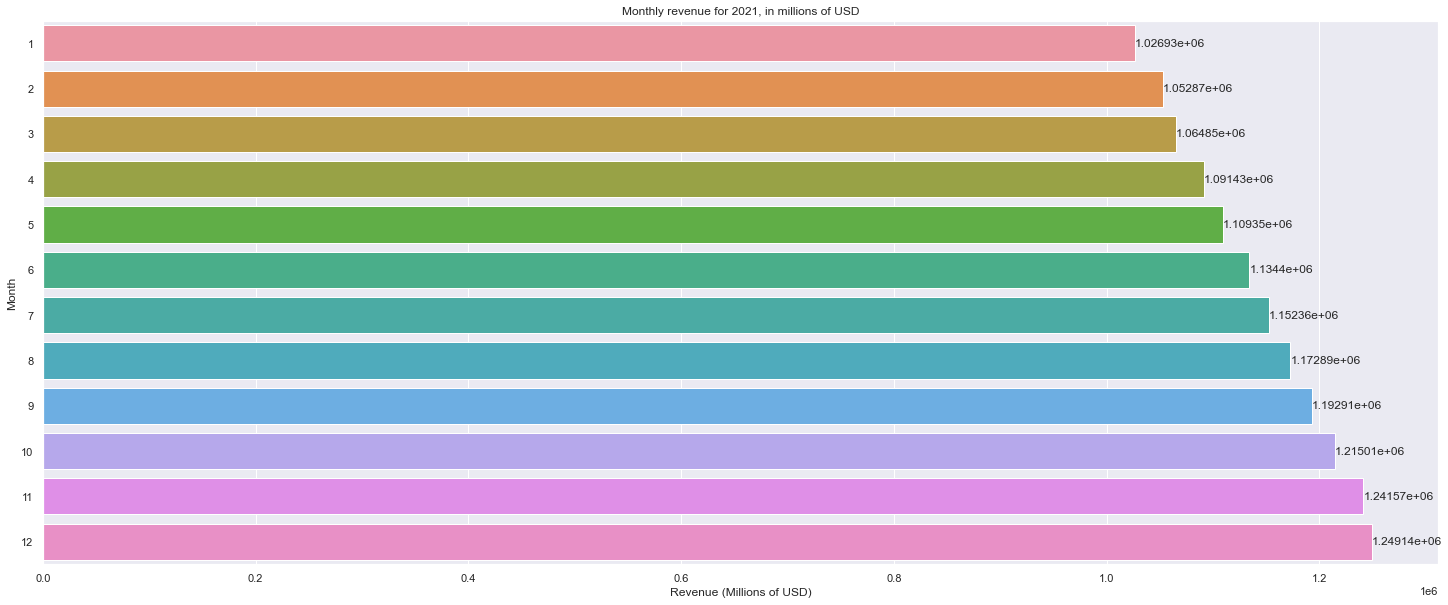

In [36]:
plt.figure(figsize=(25,10))
fig = sns.barplot(data=df_grouped_monthly, x='amount_usd', y='month_charged_on', orient='h')
fig.bar_label(fig.containers[0])
plt.title('Monthly revenue for 2021, in millions of USD')
plt.xlabel('Revenue (Millions of USD)')
plt.ylabel('Month')

Plot quarterly revenue. 

Text(0, 0.5, 'Quarter')

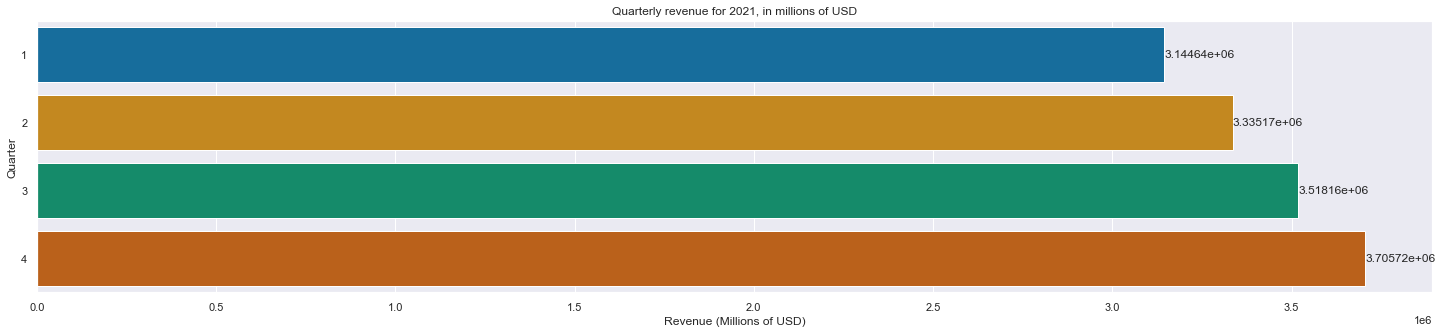

In [37]:
plt.figure(figsize=(25,5))
fig = sns.barplot(data=df_grouped_quarterly, x='amount_usd', y='quarter_charged_on', orient='h')
fig.bar_label(fig.containers[0])
plt.title('Quarterly revenue for 2021, in millions of USD')
plt.xlabel('Revenue (Millions of USD)')
plt.ylabel('Quarter')

Revenue steadily increased throughout the year, always a good sign! 

Next let's look at the distribution of revenue over the year. 

In [38]:
df_total_revenue = df_monthly_charges[['organization_id', 
                                       'amount_usd']].groupby(by=['organization_id'], as_index=False, sort=False).sum()

Text(0.5, 0, 'Revenue (USD)')

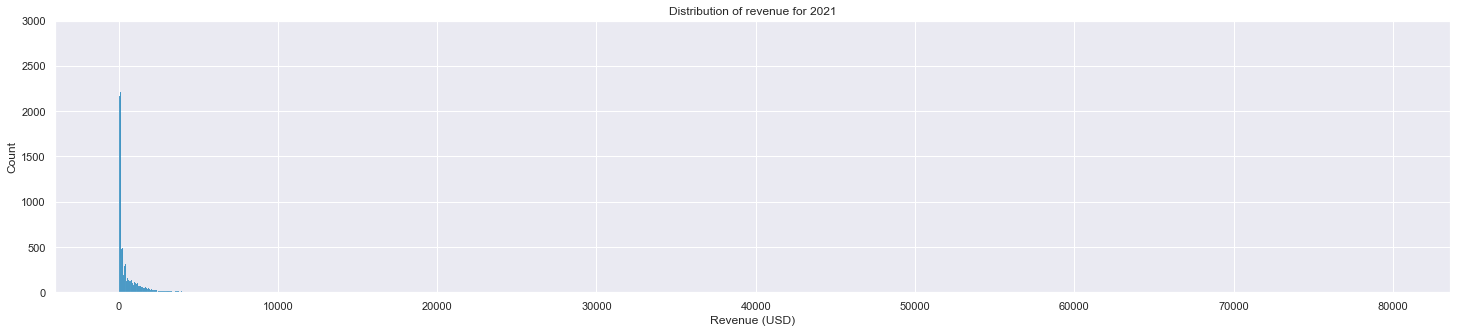

In [39]:
plt.figure(figsize=(25,5))
fig = sns.histplot(data=df_total_revenue, x='amount_usd')
plt.title('Distribution of revenue for 2021')
plt.ylim(0,3000)
plt.xlabel('Revenue (USD)')

Text(0.5, 0, 'Revenue (USD)')

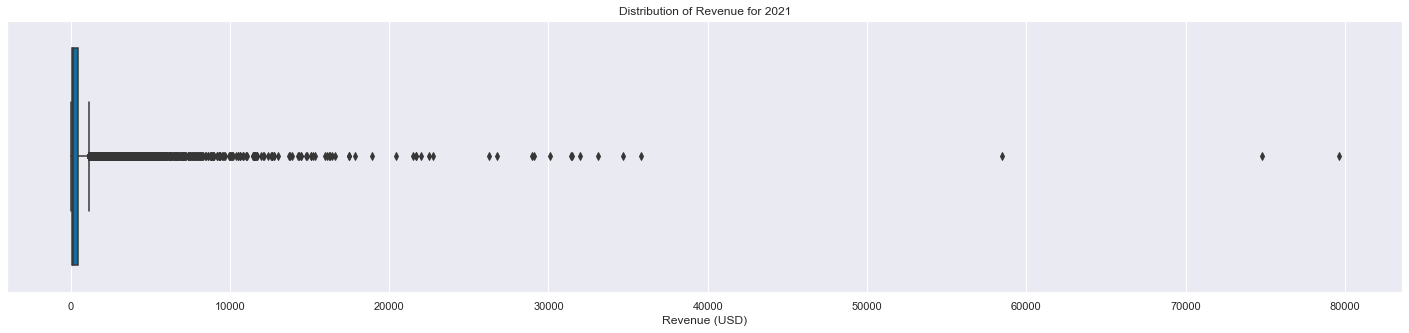

In [40]:
plt.figure(figsize=(25,5))
fig = sns.boxplot(data=df_total_revenue, x='amount_usd')
plt.title('Distribution of Revenue for 2021')
plt.xlabel('Revenue (USD)')

Revenue is not a Gaussian distribution, which is quite common when dealing with variables related to money. I shall perform a log transform on revenue to deal with this. 

In [41]:
#create column for log transformed revenue
#I could just use log_scale option in seaborn, but I'd like the column in case I need it in the future
df_total_revenue['log_revenue'] = df_total_revenue['amount_usd'].apply(lambda x: np.log(x) if x > 0 else np.nan)

Text(0.5, 0, 'Revenue (USD)')

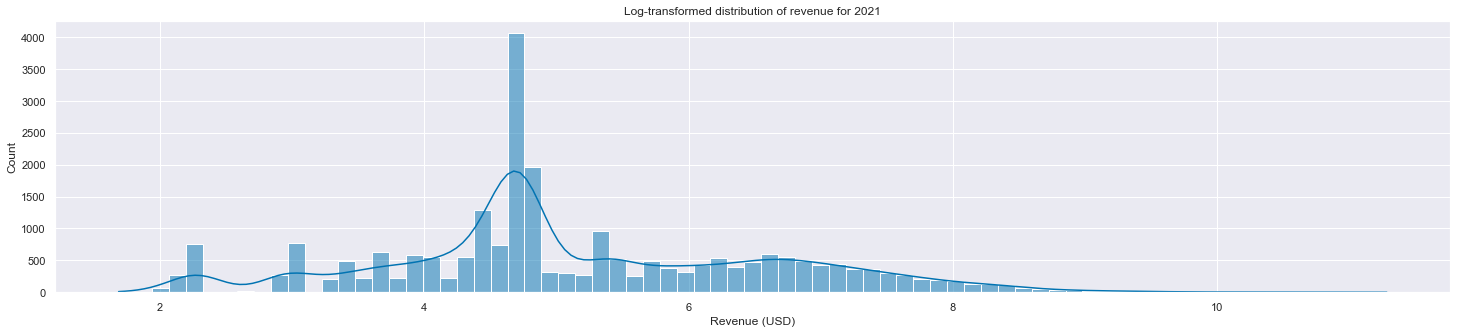

In [42]:
plt.figure(figsize=(25,5))
fig = sns.histplot(data=df_total_revenue, x='log_revenue', kde=True)
plt.title('Log-transformed distribution of revenue for 2021')
plt.xlabel('Revenue (USD)')

Text(0.5, 0, 'log of Revenue (USD)')

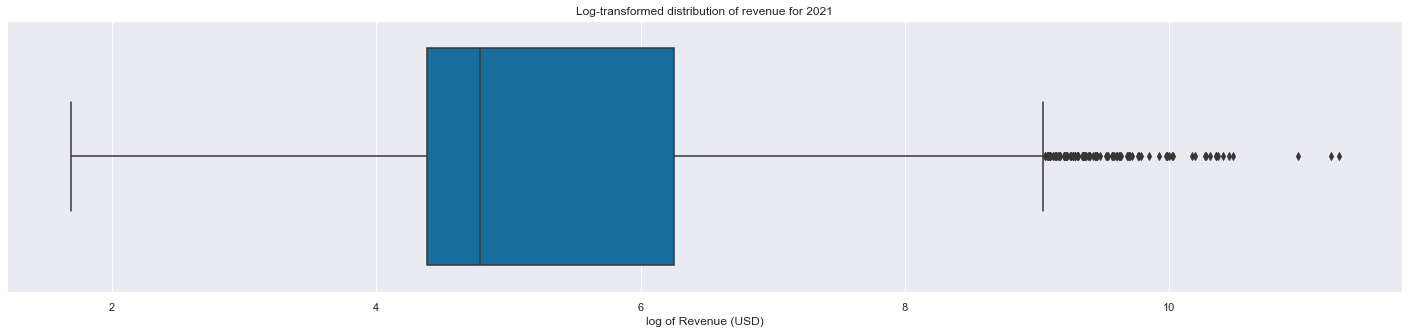

In [43]:
plt.figure(figsize=(25,5))
fig = sns.boxplot(data=df_total_revenue, x='log_revenue')
plt.title('Log-transformed distribution of revenue for 2021')
plt.xlabel('log of Revenue (USD)')

In [44]:
df_total_revenue.describe()

,organization_id,amount_usd,log_revenue
count,2.516600e+04,25166.000000,24646.000000
mean,3.878036e+06,544.532238,5.160760
std,1.149635e+06,1544.805694,1.467903
min,1.100000e+01,0.000000,1.686399
25%,3.345872e+06,72.000000,4.382027
50%,3.999310e+06,120.000000,4.787492
75%,4.544264e+06,495.000000,6.253829
max,5.911459e+06,79612.900000,11.284931


In [47]:
first_quartile = np.exp(4.382027)
third_quartile = np.exp(6.253829)
outlier = np.exp(9)
print(f'First quartile is {first_quartile}\nThird quartile is {third_quartile}\nOutliers lie above {outlier}')


First quartile is 80.0000292260948
Third quartile is 520.000097980763
Outliers lie above 8103.083927575384


Looking at the transformed data, my first instinct in a work setting would be to ask "What range of revenue are we interested in?".

We can see that there is an extremely large range of values for revenue, so it would be prudent to narrow down the range that is relevant to the project.
Otherwise, even basic questions might become difficult to answer. 

As it is, if I were to narrow in on the best/worst customers based on these graphs, I would be looking at customers who spent a grand total of $7 over the entire year, which might not be of interest to the growth team. And top spenders would range from $8000 to $80000.

So as an example, the growth team might only be interested in customers with revenues above $10000, in which case I would focus the dataframe on those columns and look for outliers within that distribution.

Next I want to look at the trend of figures over the year. So, the number of orgs, number of sales, revenue etc. All grouped by plan and type to see how these are doing.

In [49]:
df_by_plan_period = pd.read_csv(PROCESSED_DIR/figures_by_plan_period)
df_by_plan_period.head(5)

,plan,month,quarter,monthly_count,qtr_count,count_by_plan,total_count,monthly_sales_driven,qtr_sales_driven,sales_driven_by_plan,total_sales_driven,monthly_revenue,qtr_revenue,revenue_by_plan,total_revenue
0,NaN,1,1,606,1864,6754,222110,5,24,71,2805,0.0,0.0,0.0,13703698.29
1,NaN,2,1,760,1864,6754,222110,4,24,71,2805,0.0,0.0,0.0,13703698.29
2,NaN,3,1,498,1864,6754,222110,15,24,71,2805,0.0,0.0,0.0,13703698.29
3,NaN,4,2,505,1532,6754,222110,6,18,71,2805,0.0,0.0,0.0,13703698.29
4,NaN,5,2,562,1532,6754,222110,7,18,71,2805,0.0,0.0,0.0,13703698.29


Text(26.691050694444442, 0.5, 'Month')

<Figure size 1800x1080 with 0 Axes>

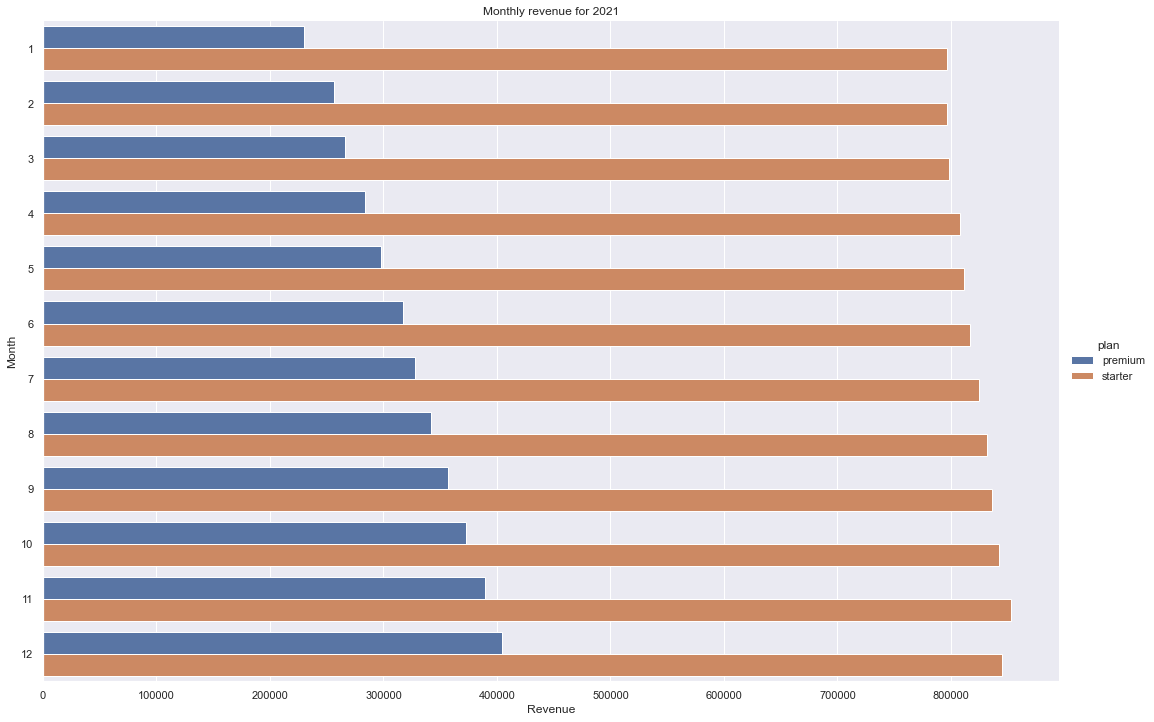

In [51]:
#Group by plan
data = df_by_plan_period[['plan',
                          'month',
                          'monthly_count',
                          'monthly_sales_driven',
                          'monthly_revenue']].groupby(by=['plan','month'], as_index=False).sum()

sns.set_theme(style='darkgrid', palette='deep')
plt.figure(figsize=(25,15))
fig = sns.catplot(data=data, x='monthly_revenue', y='month', orient='h', hue='plan', kind='bar', height=10, aspect=1.5)
plt.title('Monthly revenue for 2021')
plt.xlabel('Revenue')
plt.ylabel('Month')

In [53]:
#get type grouped data
df_by_type_period = pd.read_csv(PROCESSED_DIR/figures_by_type_period)
df_by_type_period.head(5)

,type,month,quarter,monthly_count,qtr_count,count_by_type,total_count,monthly_sales_driven,qtr_sales_driven,sales_driven_by_type,total_sales_driven,monthly_revenue,qtr_revenue,revenue_by_type,total_revenue
0,Churned,1,1,606,1864,6754,222110,5,24,71,2805,0.0,0.0,0.0,13703698.29
1,Churned,2,1,760,1864,6754,222110,4,24,71,2805,0.0,0.0,0.0,13703698.29
2,Churned,3,1,498,1864,6754,222110,15,24,71,2805,0.0,0.0,0.0,13703698.29
3,Churned,4,2,505,1532,6754,222110,6,18,71,2805,0.0,0.0,0.0,13703698.29
4,Churned,5,2,562,1532,6754,222110,7,18,71,2805,0.0,0.0,0.0,13703698.29


Text(27.37885393518519, 0.5, 'Month')

<Figure size 1800x1080 with 0 Axes>

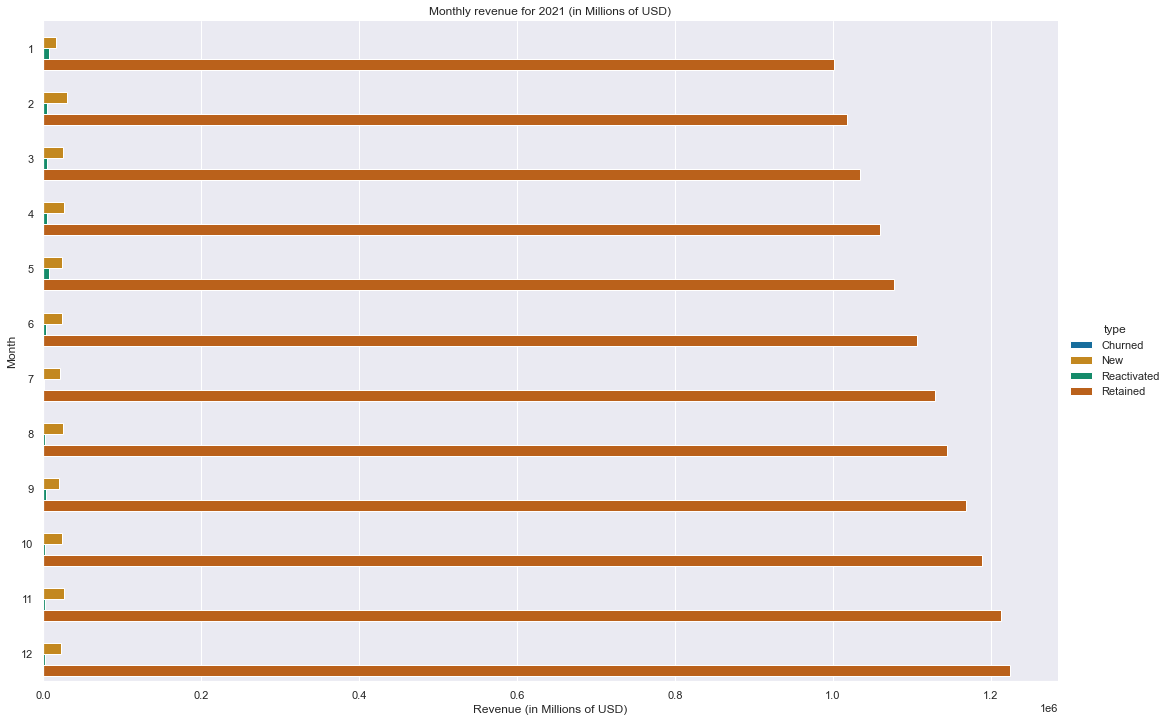

In [54]:
#Group by type and plot
data = df_by_type_period[['type',
                          'month',
                          'monthly_count',
                          'monthly_sales_driven',
                          'monthly_revenue']].groupby(by=['type','month'], as_index=False).sum()

sns.set_theme(style='darkgrid', palette='colorblind')
plt.figure(figsize=(25,15))
fig = sns.catplot(data=data, x='monthly_revenue', y='month', orient='h', hue='type', kind='bar', height=10, aspect=1.5)
plt.title('Monthly revenue for 2021 (in Millions of USD)')
plt.xlabel('Revenue (in Millions of USD)')
plt.ylabel('Month')

This would indicate most of our revenue comes from long term customers who are mostly on the starter plan.

Next I want to look at our sales efforts. What were the number of conversions by our sales team? Any noticeable patterns/lulls/spikes which might be worth investigating?

Text(0, 0.5, 'Count')

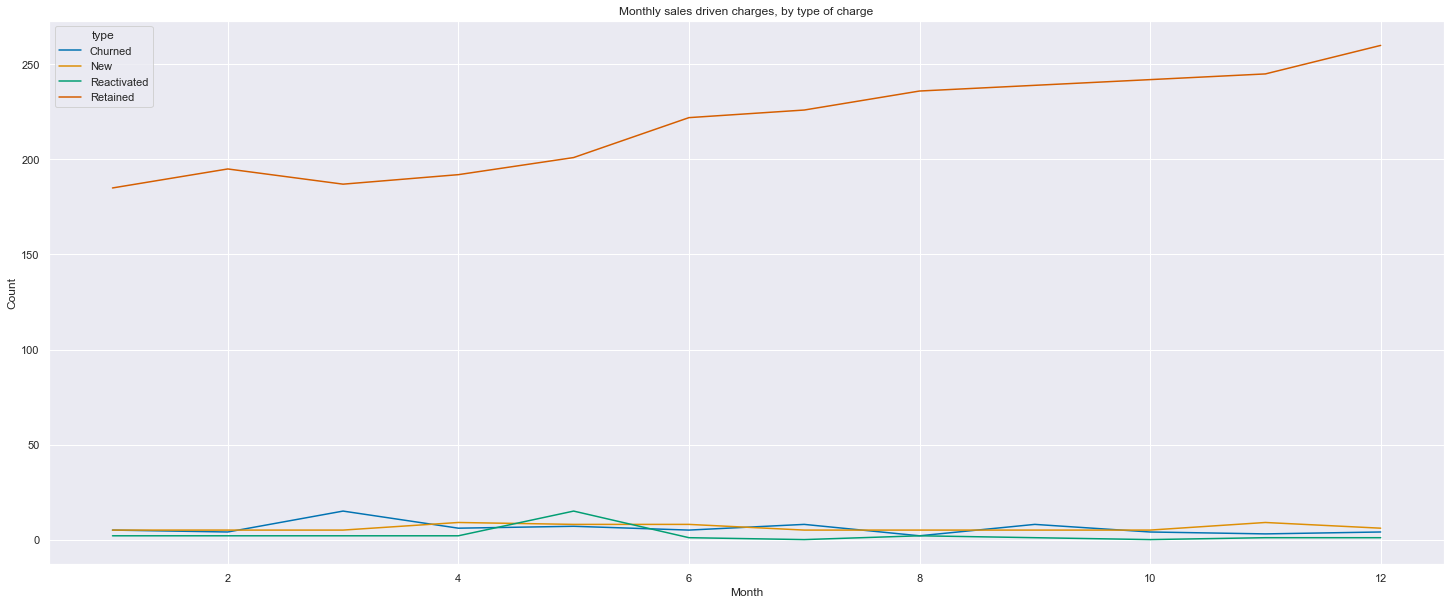

In [55]:
data = df_by_type_period[['type',
                          'month',
                          'monthly_count',
                          'monthly_sales_driven',
                          'monthly_revenue']].groupby(by=['type','month'], as_index=False).sum()

sns.set_theme(style='darkgrid', palette='colorblind')
plt.figure(figsize=(25,10))
fig = sns.lineplot(data=data, x='month', y='monthly_sales_driven', hue='type')
plt.title('Monthly sales driven charges, by type of charge')
plt.xlabel('Month')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

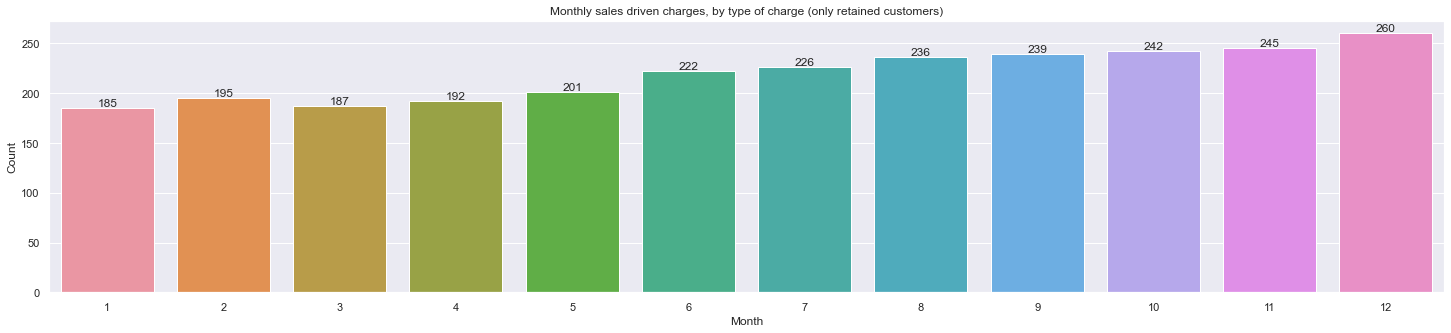

In [56]:
data = df_by_type_period[['type',
                          'month',
                          'monthly_count',
                          'monthly_sales_driven',
                          'monthly_revenue']].groupby(by=['type','month'], as_index=False).sum()

sns.set_theme(style='darkgrid', palette='colorblind')
plt.figure(figsize=(25,5))
fig = sns.barplot(data=data[(data['type'] == 'Retained')], x='month', y='monthly_sales_driven')
fig.bar_label(fig.containers[0])
plt.title('Monthly sales driven charges, by type of charge (only retained customers)')
plt.xlabel('Month')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

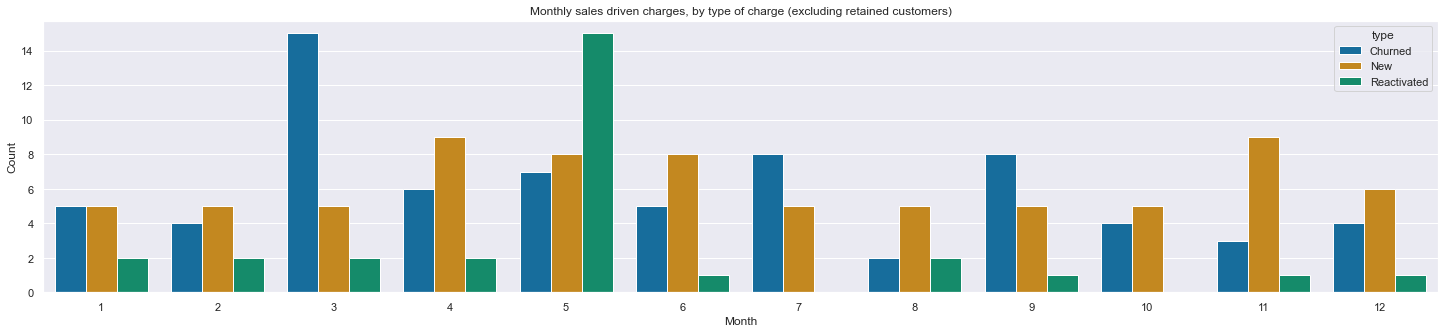

In [57]:
data = df_by_type_period[['type',
                          'month',
                          'monthly_count',
                          'monthly_sales_driven',
                          'monthly_revenue']].groupby(by=['type','month'], as_index=False).sum()

sns.set_theme(style='darkgrid', palette='colorblind')
plt.figure(figsize=(25,5))
fig = sns.barplot(data=data[~(data['type'] == 'Retained')], x='month', y='monthly_sales_driven', hue='type')
plt.title('Monthly sales driven charges, by type of charge (excluding retained customers)')
plt.xlabel('Month')
plt.ylabel('Count')

Looks like there was an uptick of churned customers related to sales efforts in March, and also a significant jump in customers who reactivated their subscription in May! We may want to look into any campaigns/efforts the sales team had in these months. 

Next, let's analyze some groups. Just for this exercise I shall focus on the outliers and the mode. So I shall look at customers with over e^10 ~= $22000 in revenue, as well as those between e^4.5 ~= $90 and e^5.5 ~= $250.
